# Visión por Computador: Trabajo Final

In [1]:
# Base
import numpy as np
import functools
from scipy.io import loadmat
from functools import partial
import pandas as pd
import os
import warnings

# Sklearn
from sklearn.model_selection import train_test_split

# Plotting
from matplotlib.image import imread
from matplotlib import patches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

# fastai
from fastai.utils import show_install, check_perf
from fastai.utils.mem import gpu_mem_get_all
from fastai import *
from fastai.callbacks import CSVLogger
from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.vision import *
from fastai.metrics import accuracy
import torchvision.models as torch_models
from efficientnet_pytorch import EfficientNet

SEED = 1234

In [2]:
show_install()
check_perf()
gpu_mem_get_all()



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.60
fastprogress  : 0.2.2
torch         : 1.3.1
nvidia driver : 418.87
torch cuda    : 10.1.243 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.15.0-1066-azure-x86_64-with-debian-stretch-sid
distro        : Ubuntu 16.04 xenial
conda env     : py36
python        : /anaconda/envs/py36/bin/python
sys.path      : 
/anaconda/envs/py36/lib/python36.zip
/anaconda/envs/py36/lib/python3.6
/anaconda/envs/py36/lib/python3.6/lib-dynload
/anaconda/envs/py36/lib/python3.6/site-packages
/anaconda/envs/py36/lib/python3.6/site-packages/IPython/extensions
/data/home/antonio/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Running performance checks.

*** libjpeg-turbo status
✘ libjpeg-turbo is not o

[GPUMemory(total=11441, free=11430, used=11)]

# Introducción

## Objetivos

El objetivo principal de este proyecto es el de crear un clasificador para
la base de datos de [coches de Stanford](https://ai.stanford.edu/~jkrause/cars/car_dataset.html), aplicando técnicas de transferencia
de conocimiento y *fine-tuning*.

Además, una comparativa de las diferentes arquitecturas preentrenadas que podemos utilizar para este problema, así como
el uso de técnicas de entrenamiento modernas, se corresponderían con los objetivos secundarios.

## Proceso
Antes de comenzar, vamos a explicar el proceso o flujo de trabajo
que hemos seguido en el desarrollo de este proyecto.
Este proceso se compone de diferentes pasos, todos con el propósito de obtener un buen modelo a partir de los datos que tenemos. Los pasos son los siguientes:

1. **Definición del problema:** Se realiza una definición informal del problema y de los supuestos que hacemos.

2. **Análisis exploratorio:** Analizamos los datos para obtener información relevante para los pasos siguientes o
para verificar los supuestos.

3. **Preparación de los datos:** En este paso realizamos todas las transformaciones convenientes sobre los datos.

4. **Modelado o Spot-Checking:** Valoramos las propuestas de los diferentes modelos preentrenados disponibles para esta tarea. Decidimos el modelo base a utilizar y el procedimiento de *fine-tuning* que nos permitirá adaptar dicho modelo a nuestros datos.

5. **Modelo final:** Finalmente seleccionamos el modelo final y lo entrenamos con el conjunto entero de datos.

6. **Resultados:** Un resumen de los resultados obtenidos hasta el momento.

# Definición del problema

El problema al que nos enfrentamos, es un problema de clasificación de imágenes de grano fino basado en el conjunto
de datos [Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html).
En este conjunto tenemos imágenes de diferentes coches y nuestro objetivo es el predecir tanto el modelo como la marca. Aunque este conjunto de datos ha sido modelo de estudio en diferentes ocasiones, nosotros vamos a intentar construir un buen modelo predictivo en base a nuestro conocimiento y a la literatura existente, 
acercándonos al estado del arte para este conjunto.

# Análisis Exploratorio

Antes de comenzar a analizar los datos, es importante estudiar la procedencia de los mismos y el formato en el que los disponemos.

Para el caso de esta base de datos, disponemos 
de dos ficheros comprimidos que contienen las 
imágenes en formato JPG, otro fichero comprimido 
que contiene los metadatos y las etiquetas de 
las imágenes de entrenamiento, y por último, tenemos
un fichero aparte con las etiquetas del conjunto de
test. Los creadores de esta base de datos tienen un
sistema de evaluación de predicciones online, pero nosotros,
por simpleza, hemos decidido descargar las etiquetas de test
para poder evaluar el modelo final en el mismo experimento,
sin depender de servicios externos.


Cabe mencionar que hay disponible un comprimido con todas las
imágenes tanto de entrenamiento como de prueba así como un
fichero de metadatos común. Este fichero unificado es útil
cuando queremos modificar la partición de datos y utilizar por
ejemplo un esquema 80-20 o incluso estimar el error fuera de la
muestra usando validación cruzada. Como queremos hacer una
comparativa con el estado del arte actual, nos interesa mantener
los mismos conjuntos de datos que han sido usados por la literatura
existente. Por este motivo, vamos a respetar las particiones existentes.

El formato en el que nos encontramos los metadatos y anotaciones
es el formato *.mat* de Matlab. Para simplificar el posterior
desarrollo representamos los metadatos en un *DataFrame* de *pandas*
con la siguiente estructura:

In [3]:
DATA_FOLDER = 'images'
TRAIN_METADATA = os.path.join(DATA_FOLDER, 'devkit/cars_train_annos.mat')
TEST_METADATA = os.path.join(DATA_FOLDER, 'cars_test_annos_withlabels.mat')
CLASSES_METADATA = os.path.join(DATA_FOLDER, 'devkit/cars_meta.mat')
TRAIN_IMAGES = os.path.join(DATA_FOLDER, 'cars_train')
TEST_IMAGES = os.path.join(DATA_FOLDER, 'cars_test')

def process_mat(mat, classes, images_dir):
    columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'filename']
    data = [np.concatenate(arrays, axis=None) for arrays in mat['annotations'][0]]
    result = pd.DataFrame(data, columns=columns)
    result = result.apply(lambda col: pd.to_numeric(col, errors='ignore'))
    result['className'] = result['class'].apply(lambda i: classes[i-1])
    result['filename'] = result['filename'].apply(lambda f: os.path.join(images_dir, f))
    return result

def load_dataset_metadata():
    train_mat = loadmat(TRAIN_METADATA)
    test_mat = loadmat(TEST_METADATA)
    classes_mat = loadmat(CLASSES_METADATA)
    classes = classes_mat['class_names'][0]
    classes = np.concatenate(classes, axis=None)
    train_data = process_mat(train_mat, classes, TRAIN_IMAGES)
    test_data = process_mat(test_mat, classes, TEST_IMAGES)
    return train_data, test_data

In [4]:
train, test = load_dataset_metadata()

In [5]:
train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,filename,className
0,39,116,569,375,14,images/cars_train/00001.jpg,Audi TTS Coupe 2012
1,36,116,868,587,3,images/cars_train/00002.jpg,Acura TL Sedan 2012
2,85,109,601,381,91,images/cars_train/00003.jpg,Dodge Dakota Club Cab 2007
3,621,393,1484,1096,134,images/cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,14,36,133,99,106,images/cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012


Como se puede observar, disponemos de 8144 muestras de entrenamiento (igual que en test). Los datos también contienen 
unos bounding box que pueden ser útiles para reducir el tamaño de las imágenes y para eliminar partes del fondo que pueden 
confundir al clasificador. Tambíen, hemos añadido el nombre de 
la clase (Marca-Modelo-Año) para facilitar la inspección 
de los datos y la depuración e interpretación de modelos.

Por otra parte, como los datos son bastante pesados como para
tenerlos en memoria, hemos añadido una columna para almacenar
la ruta de la imagen. De esta forma, dado el DataFrame de datos
podemos crear un generador para cargar las imágenes bajo demanda.

In [6]:
def render_image(img, title=None, ax=None, bounding_box=None):
    """Renderiza una imagen a color con un titulo y un bounding box opcionales"""
    if not ax:
        ax = plt.gca()
    ax.imshow(img)
    ax.set_axis_off()
    if bounding_box:
        min_x, max_x, min_y, max_y = bounding_box
        width = max_x - min_x
        height = max_y - min_y
        rect = patches.Rectangle(
            (min_x, min_y), width, height,
            linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    if title:
        ax.set_title(title)
    if not ax:
        plt.show()


def render_grid(images, titles, rows=1, bounding_boxes=None, suptitle=None, figsize=None):
    """Renderiza un grid de imagenes con sus títulos correspondientes"""
    num_imgs = len(images)
    cols = num_imgs // rows + num_imgs % rows
    figsize = figsize if figsize else (12, rows * 3)
    fig = plt.figure(figsize=figsize)
    grid_shape = (rows, cols)
    gs = fig.add_gridspec(*grid_shape)
    fig.tight_layout()
    for i, (img, title) in enumerate(zip(images, titles)):
        bbox = bounding_boxes[i] if bounding_boxes else None
        ax = fig.add_subplot(gs[i // cols, i % cols])
        render_image(img, title=title, bounding_box=bbox, ax=ax)
    if suptitle:
        plt.suptitle(suptitle)
    plt.show()

In [7]:
def show_batch(data, n=12):
    sample = train.sample(n, random_state=SEED)
    bounding_boxes = sample[['bbox_x1', 'bbox_x2', 'bbox_y1', 'bbox_y2']]
    bounding_boxes = bounding_boxes.values.tolist()
    rows = n // 3
    images = [imread(filename) for filename in sample['filename']]
    render_grid(images, sample['className'], rows, bounding_boxes)

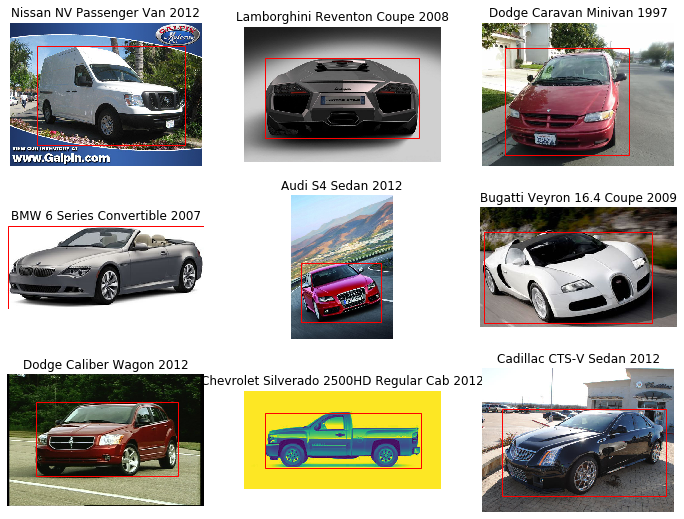

In [8]:
show_batch(train, 9)

En la imagen anterior podemos ver una muestra del conjunto 
de entrenamiento. Como vemos, las imágenes están centradas 
en el objeto que queremos clasificar y los bounding boxes se
ajustan bastante bien ya que es muy probable que estén etiquetados
a mano.

También hay que destacar que las imagenes no son todas del mismo
tamaño. Este factor lo debemos tener en cuenta a la hora de
diseñar el pipeline de preprocesado y/o aumento de datos,
las dimensiones de entrada de la red deben coincidir con los datos con los que se le alimenta. Además, el ratio de aspecto también 
es diferente entre las imágenes.
Debemos tener cuidado en el momento de recortarlas,
sobre todo en aquellas muy apaisadas, para no eliminar
información relevante que afecte negativamente al clasificador.

Por otro lado, hay algunas imágenes que no son de vehiculos reales
o que contienen un marco. Esto puede deteriorar también el comportamiento del modelo, ya sea añadiendo bias o eliminando capacidad de generalización. En el caso de las imágenes con marco, habría que estudiar las zonas de máxima atención del modelo y comprobar que se corresponden con la parte del vehiculo
y no la del marco.

In [9]:
#####################################
# DEFINICIÓN DE FUNCIONES DE PLOTTING
#####################################

def configure_plotting():
    """
    Set plotting aesthetics.
    """
    rc_params = {
        'savefig.dpi': 300,
        'figure.autolayout': False,
        'figure.figsize': (10, 6),
        'axes.labelsize': 18,
        'axes.titlesize': 20,
        'font.size': 20,
        'font.family': 'serif',
        'lines.linewidth': 2.0,
        'lines.markersize': 8,
        'legend.fontsize': 14
    }
    sns.set('paper', 'white', font_scale=1.2, rc=rc_params)


def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()


def plot_accuracy(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()


def countplot(df, ax=None, figsize=(10,6)):
    plot = sns.countplot('class', data=df, ax=ax)
    plot.set(xticklabels=[])
    if not ax:
        plt.show()

In [14]:
configure_plotting()

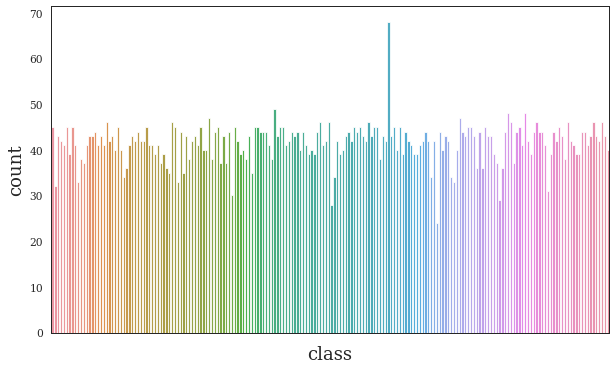

In [15]:
countplot(train)

En la imagen anterior podemos ver un histograma con la cantidad de
ejemplos de cada clase. El nombre de la clase no es relevante, así que se ha omitido. Lo importante es comprobar que el conjunto está
balanceado y no hay unas pocas clases predominantes sobre el resto.
La mayoría de clases disponen de entre 30 a 50 ejemplos,
lo cuál tampoco es un número muy grande para un ajuste de 
grano fino. Solamente hay una clase predominante con casi 70 ejemplos, pero no podemos considerar el conjunto como desbalanceado.

# Modelado o Spot-Checking

## Separación del conjunto de entrenamiento

Para poder evaluar el rendimiento de los modelos
sin utilizar el conjunto de test, vamos a 
a realizar una partición 80-20 del conjunto 
de entrenamiento, donde el 20% se reserva para
el conjunto de validación. Aunque el conjunto
no está desbalanceado, es recomendable hacer
una partición de los datos de manera
estratificada para que todas las clases esten
representadas por igual en ambos conjuntos.

El motivo principal por el que no utilizamos el
conjunto de test para evaluar nuestros modelos
a lo largo de las épocas, es para evitar introducir sesgo
y hacer una comparativa justa con el estado del arte actual.

In [25]:
def stratified_df_split(df, test_size=0.2):
    """
    Divide un dataframe de manera estratificada.
    Esta función era necesaria cuando usabamos Keras pero
    el framework de fastai ya la incluye internamente
    a la hora de crear nuestro generador de datos.
    La hemos dejado para que se pueda ver visualmente
    las particiones que se hacen de forma interna.
    """
    X = df.copy()
    y = X.pop('className').to_frame()
    X_train, X_val, y_train, y_val = train_test_split(
        X,
        y,
        stratify=y,
        test_size=test_size,
        random_state=SEED
    )
    train_data = pd.concat([X_train, y_train], axis=1)
    val_data = pd.concat([X_val, y_val], axis=1)
    return train_data, val_data

In [12]:
train_data, val_data = stratified_df_split(train)

De hecho podemos comprobarlo simplemente dibujando el histograma resultante de cada partición:

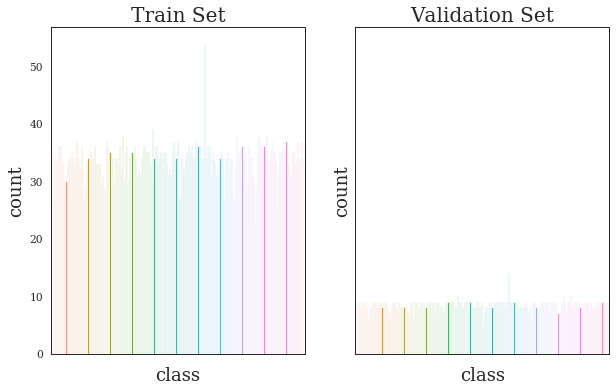

In [17]:
fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].set_title('Train Set')
axes[1].set_title('Validation Set')
countplot(train_data, ax=axes[0])
countplot(val_data, ax=axes[1])
fig.show()

## Fine-Tuning Multietapa

A la hora de hacer transferencia de conocimiento,
vamos a utilizar un procedimiento multietapa.
En una primera etapa utilizamos la red preentrenada
como extractor de características: le quitamos el
clasificador y congelamos el resto de capas. A esta
arquitectura le añadimos un clasificador cuya capa
de salida tenga de tamaño el número de clases 
que estamos tratando y tenga activación Softmax. El clasificador que se le añade
a la red preentrenada consiste en una combinación de
AdaptiveConcatPool2d + Flatten + BatchNormalization + Dropout + Linear + Relu + Linear + Softmax.

La primera capa de AdaptiveConcatPool2d utiliza AveragePooling adaptativo
junto con MaxPooling adaptativo y concatena ambos. Utilizamos esta capa porque provee la información
de ambos métodos y tiende a mejorar el rendimiento. Además, al ser un Pooling adaptativo, el tamaño de
ventana que utiliza varía para tener siempre las mismas dimensiones de salida, independientmente
del tamaño de la imagen de entrada.

Como AdaptiveConcatPool2d tiene como salida una matriz de dos filas (una por cada
método), es necesario aplicar una capa Flatten para tener un solo vector
con el cual alimentar al clasificador. El resto de capas es un stack bastante
común, se utiliza BN para mejorar el rendimiento en el entrenamiento, Dropout
con probabilidad de descarte de $0.5$ como método de regularización agresivo y
un capa lineal interna de 512 neuronas.

En las siguientes etapas se va refinando el modelo, descongelando
más capas y entrenando con un ratio de aprendizaje menor, normalmente
un 1/100 de la etapa anterior. Como la parte preentrenada, sobre todo
los primeros módulos convolucionales, extraen características de bajo nivel
como contornos y lineas, no nos interesa hacer cambios muy bruscos en los
pesos. Por este motivo, hemos utilizado otra técnica novedosa que consiste
en asignar un ratio de aprendizaje a cada capa (o grupo de capas) por separado [@layerSpecificLR].
Esto nos permite asignar un ratio de aprendizaje (o multiplicador) alto en
las últimas capas (el clasificador) e ir disminuyéndolo conforme nos acercamos a las primeras capas.
Aunque esta característica no está soportada nativamente por Keras,
los desarrolladores de Fast.ai si que la han tenido en cuenta y la han implementado
para nuestra comodidad.

> Como estamos limitados computacionalmente, el numero de etapas
de este proceso va a ser de 2, es decir, entrenar el clasificador solo + descongelar toda la red y entrenar.

## Entrenamiento eficiente

Para obtener modelos competentes en un tiempo reducido, hemos
tenido en consideración algunas de las técnicas actuales para
el entrenamiento eficiente en Deep Learning.

Como bien sabemos, uno de los hiperparámetros más importantes
es el ratio de aprendizaje. Un ratio de aprendizaje bajo puede
hacer que tardemos demasiado en converger (además de producir
overfitting), mientras que un ratio
demasiado alto puede hacer que el modelo diverga y salga del mínimo.
Es por eso que recientemente se han desarrollado estudios que
tratan de abordar el problema de seleccionar el ratio 
de aprendizaje adecuado. Pero no basta con seleccionar el ratio,
es necesario también encontrar una forma óptima de actualizarlo
a lo largo de las épocas para afinar el entrenamiento.

Teniendo lo anterior en cuenta, para todas las arquitecturas
propuestas se va a utilizar un esquema de entrenamiento con ratio
de aprendizaje cíclico [1]. Este tipo de esquema consiste en dos pasos - uno en el que se incrementa el ratio 
desde un mínimo hasta el máximo y otra en la que se decrementa.

Para encontrar el mínimo y el máximo adecuado se utiliza una
técnica llamada LR Range test [@rangeTest]. En esta técnica, partimos de un
ratio de aprendizaje muy bajo (1e-10 por ejemplo), y entrenamos
la red incrementando exponencialmente el ratio de aprendizaje hasta llegar
a un máximo, normalmente 1. El incremento se realiza en cada
nuevo batch, a la vez que se almacena el loss actual. Una vez
se ha alcanzado el máximo que suele tardar entre 1 y 5 épocas,
se dibuja una gráfica con el loss. Dicha gráfica nos permite ver
cuando un ratio de aprendizaje hace que el loss se dispare
o bien, hace que descienda muy lentamente. Con esta información
podemos seleccionar nuestro rango para el esquema de actualización
del ratio.

La política de actualización cíclica que vamos a utilizar se llama
One-Cycle [@oneCycle]. Consiste en una politica triangular básica
(se aumenta y decrementa linealmente el ratio de aprendizaje),
pero solamente se realiza un ciclo en todo el entrenamiento.
Además, la duración del ciclo debe ser un poco menor que el
número de epocas. Una vez se ha completado el ciclo, el ratio
de aprendizaje se reduce drásticamente (en 1 o 2 escalas) y se
mantiene hasta terminar el entrenamiento.

El fundamento principal de esta técnica es que durante el 
la mitad del entrenamiento cuando el ratio es muy alto,
este actúa de regularizador y previene que la red sufra
overfitting [@superconvergence]. Esto es similar a un método
bastante conocido como es el de enfriamiento simulado,
en el que a lo largo de las iteraciones se va reduciendo
la probabilidad de aceptar soluciones más alejadas, por lo que
únicamente se aceptan saltos pequeños en el espacio de soluciones.

El paper que recoge la técnica de One-Cycle también propone 
un esquema cíclico para el momentum (decreciente) y un valor constante para el weight decay.
El obtener el valor del 
weight decay y un rango de valores óptimo para el momentum se basa en realizar
una búsqueda por el espacio de hiperparámetros 
usando técnicas de hiperparametricación como GridSearch.
Como estamos limitamos computacionalmente, hemos optado 
por establecer un rango fijo para el momentum (0.85-0.99) y 
el valor por defecto para el weight decay que suelen dar buenos resultados.

Por otra parte, todos los modelos se entrenan con un tamaño de
batch de 32. No podemos usar un número muy alto porque
estamos limitados por la memoria de la GPU, sobre todo al entrenar
redes que utilizan BatchNormalization.

## Aumento de datos

Como disponemos de una cantidad de imágenes muy limitada para
entrenamiento (< 7000k), es necesario realizar aumento de datos
para obtener una buena capacidad de generalización. Teniendo
en cuenta el tipo de imágenes que estamos tratando,
hemos decidido utilizar las siguientes transformaciones para
todos los modelos:

|          Transformación         | Probabilidad |  Valores  |
|:-------------------------------:|:------------:|:---------:|
|         Flip horizontal         |      0.5     |           |
|             Rotación            |     0.75     | [-10, 10] |
| Deformación simétrica aleatoria |     0.75     |    0.2    |
|               Zoom              |     0.75     |    1.1    |
|         Luz y contraste         |     0.75     |    0.2    |


Algunas arquitecturas suponen los datos reescalados entre [0,1],
otras en BGR con escala en 255, otras requieren los datos 
en estilo Caffe, etc. Por este motivo, es necesario aplicar 
a parte de las transformaciones anteriores, una función de preprocesado
dependiente de la arquitectura que se encargue de preparar los datos
para introducirlos en la red.

Aparte de estas transformaciones, sobre todo en las arquitecturas
más complejas, es necesario aplicar algunas técnicas de aumento de 
datos más novedosas para aumentar la capacidad de generalización. 

Una técnica que vamos a aplicar es **Mixup** [@mixup], que consiste en 
entrenar el modelo con mezclas de 2 imágenes del conjunto de entrenamiento
(no necesariamente de la misma clase) con una proporción $t$ en [0, 1] y
realizar una combinación lineal entre ambas. En términos de tensores, tenemos:

$$nueva\_imagen = t * imagen_1 + (1-t) * imagen_2$$

A su vez, la etiqueta asociada a esta nueva imagen viene dada por la combinación lineal
de las etiquetas de las imagenes originales (asumiendo que están codificadas en one-hot):

$$nueva\_etiqueta = t * etiqueta_1 + (1-t) * etiqueta_2$$

A continuación se muestra un ejemplo generado con esta técnica con 2 imágenes de perro y gato
y un $t=0.7$ para el perro:

![Combinación de fotos de perro y gato con técnica MixUp](mixup.png)

Aunque a nivel de reconocimiento humano esta técnica no tenga mucho sentido, sí lo tiene para
una red neuronal, que encima entrena más eficientemente. Hay que tener en cuenta que el valor
de loss para los modelos entrenados con esta técnica será mayor que sin aplicarla, aunque el
resultado de precisión pueda ser mejor, esto es debido principalmente a que el modelo pierde
confianza en las predicciones.

Por otra parte, existe una técnica de regularización aun más novedosa llamada **Cutmix** [@cutmix].
Esta técnica consiste, al igual que la anterior, en la combinación de dos imágenes de entrenamiento.
En este caso, se selecciona un parche aleatorio de una imagen y se coloca en la otra imagen.
Esta técnica se propone como mejora a las estrategias de Dropout regional (Cutout)
que consisten en eliminar parches de las imágenes de entrada para mejorar la atención de la red hacia elementos
menos discriminativos de la imagen. Esto conlleva una perdida de información e ineficiencia en el
entrenamiento. En el caso de Cutmix, tanto la imagen generada como la etiqueta, contienen información de
dos imágenes. Las etiquetas en este procedimiento se generan de la misma forma que en *Mixup* pero
el ratio $t$ corresponde a la proporción de la imágen que ocupa el parche.
En la siguiente imagen podemos ver una comparativa de los métodos mencionados:

![Comparativa Cutmix vs Cutout vs Mixup](https://forums.fast.ai/uploads/default/original/3X/4/b/4b00023c65aa58fbe58b02271de08949e53c64b9.png)

> El ratio de proporción en ambas técnicas se selecciona para cada pareja de imagenes de manera aleatoria
de una distribución $Beta(\alpha, \alpha)$, normalmente con $\alpha=1$ (distribución uniforme).

## Modelos seleccionados

A la hora de seleccionar unas arquitecturas preentrenadas sobre las que crear nuestro clasificador,
hemos atendido a su rendimiento en ImageNet y nos hemos decantado por las siguientes:

* VGG
* ResNet
* InceptionV3
* EfficientNet
* ResNeXt

Para hacer una comparativa interesante, se han escogido arquitecturas que ofrecen 
características diferentes, en lugar de seleccionar por ejemplo Resnet50, Resnet101 y Resnet152.

En cualquier caso, lo que si se va a comparar es, dentro de una misma arquitectura, el rendimiento de cada una de las variantes de las que dispongamos. Por ejemplo, en el caso de EfficientNet, tenemos distintas variantes en función del número de parámetros (B0-B7, aunque esta última no hemos podido probarla debido a los recursos limitados de los que disponemos). También tenemos distintas variantes para VGG y ResNet, las cuáles se compararán más adelante.

Dentro de nuestro marco de entrenamiento multietapa, para la primera
etapa se ha entrenado el clasificador con el resto de la red congelada
durante 15 épocas. En la segunda etapa, se descongela el resto de la red y se
entrena durante 10 épocas más con una fracción del ratio de aprendizaje
usado en la etapa primera.

## Implementación

Durante el proceso de modelado se ha hacho uso de la biblioteca *Fast.ai*.
Esta biblioteca se implementa por encima de PyTorch y nos provee de diferentes funciones
de alto nivel para el entrenamiento. Nuestro primer enfoque fue utilizando Keras,
pero debido a un problema con las capas de BatchNormalization, el rendimiento
de las redes Inception y Resnet era muy pobre. Además, este problema ocasionaba
que para la red EfficientNet no hubiese suficiente memoria en la GPU de Google Colaboratory (2GB).

En el caso de Keras, tanto las técnicas de One-Cycle como Mixup hay que implementarlas
a mano en forma de Callback. Mientras que dichas funcionalidades, junto con el test LR Range,
vienen implementadas por defecto en Fast.ai. Además, esta biblioteca ofrece unas transformaciones
para aumento de datos más flexibles que el ImageDataGenerator de Keras, ya que se le puede especificar
la probabilidad con la que aplicar cada transformación.

In [18]:
def get_data(df, tfms=None, valid_ptc=0.2, size=224, batch_size=32):
    """
    Devuelve un ImageDatBunch de nuestro conjunto de datos.
    También se le especifica que aplique una normalización
    de acuerdo a la media y desviación tipica de ImageNet.
    En este caso estamos creando el generador en base a un
    dataframe de pandas, con las transformaciones especificadas
    en la tabla de la memoria y otros parámetros como el tamaño
    de la partición de validación, el tamaño al que se deben ajustar
    las imágenes y el tamaño de batch.
    """
    return ImageDataBunch.from_df(
        path='',
        df=df, 
        ds_tfms=tfms,
        fn_col='filename',
        label_col='className',
        valid_pct=valid_ptc,
        size=size,
        seed=SEED,
        bs=batch_size
    ).normalize(imagenet_stats)

def get_callbacks():
    """
    Devuelve los callbacks que utilizaremos en nuestro modelo.
    En este caso hemos añadido el callback ShowGraph para ver
    en tiempo real la gráfica de loss en entrenamiento y validación.
    """
    return [ShowGraph]

In [38]:
# Epocas de entrenamiento
epochs = 15
# Epocas con toda la red desbloqueada
unfreeze_epochs = 10
# Transformaciones de la tabla especificadas
# en la memoria
tfms = get_transforms()
# Datos usados para entrenamiento, con un 20%
# para validación y las transformaciones definidas
# en la tabla
data = get_data(train, tfms)
# Inception requiere las imágenes con tamaño 299x299,
# asi que es necesario crear un ImageDataBunch solo
# para este modelo
inception_data = get_data(train, tfms, size=299)

## Resultados

A continuación se muestran los resultados obtenidos para cada arquitectura. Para el caso de Resnet, VGG y EfficientNet, hemos realizado una comparativa con los tiempos de ejecución y el precisión de cada una de
sus variantes. Posteriormente, hemos seleccionado la mejor variante en relación tiempo-precisión
y hemos llevado a cabo la segunda etapa de nuestro proceso (descongelar y entrenar de nuevo).

> Todos los resultados de precisión aquí expuestos han sido calculados usando el conjunto de validación,
al final de la comparativa se valoran los modelos finales sobre el conjunto de test.

### VGG

En la siguiente gráfica podemos ver la evolución de la precisión en validación durante las distintas épocas del entrenamiento.

![Evolución de las distintas variantes de VGG](plots/vgg_acc.png)

Como se puede ver, salvo VGG11 que tiene un poco menos de precisión, el resto se comporta casi igual, siendo VGG19 la que presenta una leve mejora con respecto a VGG13 y VGG16, pero nada destacable. En concreto, los resultados en la última eṕoca han sido los siguientes:

![Accuracy VGG en la última época](plots/vgg_hist.png)

El salto más grande se produce de VGG11 a VGG13 con casi un 4% de diferencia. Si ahora comparamos teniendo en cuenta el ratio precisión / tiempo de ejecución, obtenemos lo siguiente:

![Resultados en precisión/tiempo](plots/vgg_normalized_acc.png)

En este caso, aunque VGG11 tenga un ratio mejor, el tiempo de ejecución de cualquiera de estas arquitecturas no supone un gran esfuerzo computacional, por este motivo, para hacer una comparativa más interesante,
vamos a quedarnos con el de mejor precisión, que en este caso es VGG19.

In [18]:
vgg = cnn_learner(data, models.vgg19_bn, metrics=[accuracy], callback_fns=get_callbacks())

Como se ha expuesto previamente, para entrenar un modelo primeramente vamos a averiguar que ratio de aprendizaje
máximo debemos utilizar. En concreto, para VGG19 tenemos el siguiente gráfico obtenido mediente el test LR Range.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 4.79E-03


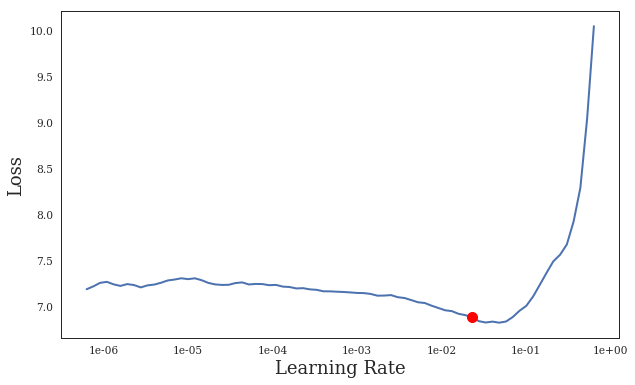

In [19]:
vgg.lr_find()
vgg.recorder.plot(suggestion=True)

Parece que tan solo hay una pequeña pendiente pronunciada que se sitúa en el rango $[10^{-2}, 10^{-1}]$.
Por tanto, el valor máximo para el learning rate será $\alpha=10^{-2}$ a la hora de ejecutar one-cycle.
El motivo por el que no seleccionamos 0.08 por ejemplo que se parece mas al valor sugerido por fastai, que corresponde con el punto más bajo, es que
debemos asegurarnos de que estamos en un punto donde la red puede entrenar eficientemente pero además,
evitando que el loss pueda dispararse. Es decir, es preferible que la red se entrene de forma segura
aunque más lenta, a que en algún punto del entrenamiento el loss empieze a dispararse. Veamos ahora en detalle como ha sido el entrenamiento de la red:

epoch,train_loss,valid_loss,accuracy,time
0,5.403067,3.860348,0.180590,01:14
1,3.740996,2.848840,0.323710,01:13
2,3.571362,2.822662,0.321253,01:13
3,3.086405,2.710668,0.338452,01:13
4,2.739050,2.344162,0.418919,01:14
5,2.402908,1.931385,0.494472,01:14
6,2.197993,1.913493,0.501229,01:14
7,1.883444,1.506576,0.595823,01:14
8,1.701395,1.419320,0.623464,01:13
9,1.419281,1.156499,0.690418,01:13


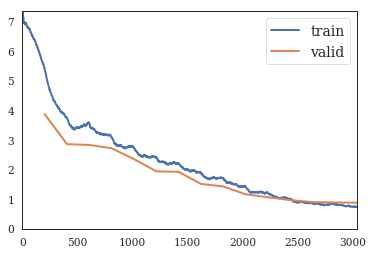

In [20]:
vgg.fit_one_cycle(epochs, max_lr=1e-2)

Los resultados para esta red son bastante buenos teniendo el cuenta el tipo de red que estamos tratando. Debido a la política One-Cycle, vemos como cuando nos acercamos al final del entrenamiento, como el learning rate se va decrementando ya que es precisamente cuando se llega a los valores mínimos, la gráfica va suavizando su pendiente, quedandose casi constante. Vamos a probar ahora a descongelar todas las capas, volveremos a ejecutar el test LR Range para ver si deberiamos cambiar el learning rate o no y entrenaremos otra vez durante 10 épocas pero con todas las capas desbloqueadas, y un rango del learning rate que se situará en el intervalo $[\frac{max\_lr}{100}, \frac{max\_lr}{10}]$, ya que nos interesa tener un lr muy moderado para no provocar una posible divergencia cuando se cambien los pesos de las capas que antes estaban congeladas.

In [22]:
vgg.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 6.31E-06


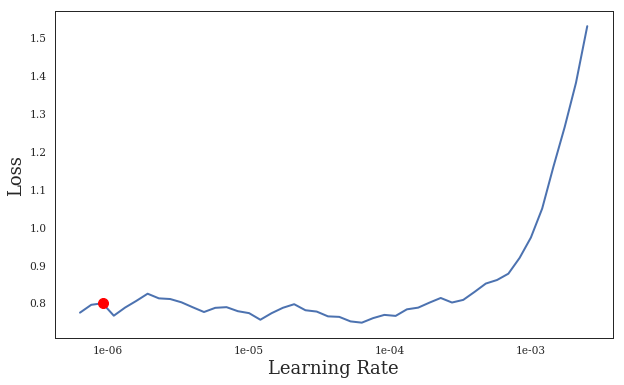

In [23]:
vgg.lr_find()
vgg.recorder.plot(suggestion=True)

Ahora parece que no tenemos una pendiente tan definida como antes. A partir de $1e-4$ la gráfica empieza a subir, por tanto nos quedaremos en el intervalo entre $1e-6$ y $1e-5$. El problema de esto es que muy probablemente no consigamos un aumento significativo de precisión ya que son valores muy bajos, pero nos aseguran al menos que el loss no va a diverger.

epoch,train_loss,valid_loss,accuracy,time
0,0.735065,0.873036,0.758600,01:40
1,0.733998,0.858079,0.764128,01:39
2,0.721520,0.850703,0.761671,01:39
3,0.678256,0.833390,0.768427,01:39
4,0.651014,0.826692,0.770885,01:39
5,0.643311,0.819223,0.773956,01:40
6,0.650577,0.810288,0.777027,01:38
7,0.630631,0.816449,0.767813,01:39
8,0.678522,0.804453,0.772727,01:38
9,0.674971,0.804720,0.776413,01:38


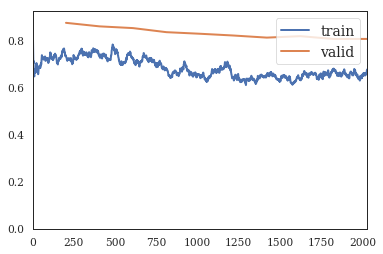

In [24]:
vgg_max_lr_unfreeze = 1e-4
vgg.fit_one_cycle(unfreeze_epochs, max_lr=slice(vgg_max_lr_unfreeze/100, vgg_max_lr_unfreeze/10))

Viendo los resultados, hemos obtenido un incremento muy pequeño, en torno a un ~2%, algo que como hemos vaticinado antes era muy probable que ocurriera. En lineas generales, nos acercamos al 80% de precisión ya en el primer modelo elegido, por lo que se auguran buenos resultados en modelos con arquitecturas más complejas como los que veremos a continuación.

### ResNet

Si realizamos una comparativa similar a la de VGG para ResNet obtenemos los siguientes resultados:

![Evolución de las distintas variantes de ResNet](plots/resnet_acc.png)

En este caso parece que tenemos unas diferencias de rendimiento entre variantes bastante más notables que antes. Veamos la precisión en la última época para cada modelo:

![Accuracy ResNet en la última época](plots/resnet_hist.png)

Como se puede ver, hay una mejora sustancial de la precisión hasta que llegamos a la conocida variante ResNet50, a partir de la cuál no se aprecia una mejora sustancial, y más si tenemos en cuenta que el tiempo de cómputo para ResNet152 es bastante superior con respecto a ResNet50.

![Resultados en precisión/tiempo](plots/resnet_normalized_acc.png)

Esta gráfica lo ha terminado de confirmar, de hecho ResNet18 y ResNet152 se posicionan como las peores, penalizadas por la precisión y por el tiempo de cómputo respectivamente, situándose ResNet50 como la mejor opción, por lo que será la que usaremos para la siguiente fase.

In [26]:
resnet = cnn_learner(data, models.resnet50, metrics=[accuracy], callback_fns=get_callbacks())

Igual que con VGG, vamos a ejecutar el test LR Range a ver qué learning rate es el que mas nos conviene.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 2.75E-03


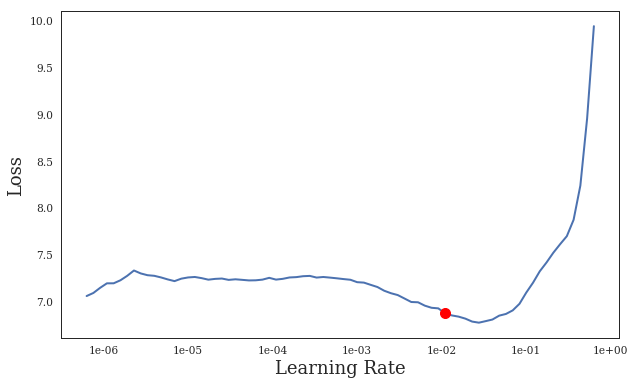

In [27]:
resnet.lr_find()
resnet.recorder.plot(suggestion=True)

En este caso parece que coincidimos plenamente con la sugerencia de fastai, de hecho la gráfica es muy parecida a la que nos salía con VGG, asi que no vamos a cambiar el valor. Veamos el resultado de cada época:

epoch,train_loss,valid_loss,accuracy,time
0,4.801078,3.365083,0.238943,00:50
1,3.521863,3.049568,0.287469,00:49
2,3.593080,3.337463,0.268428,00:48
3,3.093338,2.742723,0.340295,00:48
4,2.654883,2.441591,0.378993,00:48
5,2.321223,2.348983,0.407862,00:49
6,2.136824,1.831773,0.512899,00:48
7,1.838981,1.662023,0.544840,00:48
8,1.478788,1.480040,0.599509,00:48
9,1.248932,1.129658,0.703317,00:49


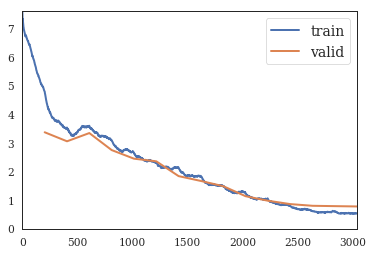

In [28]:
resnet.fit_one_cycle(epochs, max_lr=1e-2)

Como ya vimos anteriormente en la comparativa, con ResNet50 conseguimos rozar el 80% sin descongelar ninguna de las capas y con una evolución de loss muy buena tanto para validación como para entrenamiento. Vamos a descongelar todas las capas y a ejecutar el mismo pipeline que anteriormente y veamos si conseguimos superar la barrera del 80%. Aunque antes deberemos de volver a ajustar el learning rate.

In [30]:
resnet.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-05
Min loss divided by 10: 1.91E-05


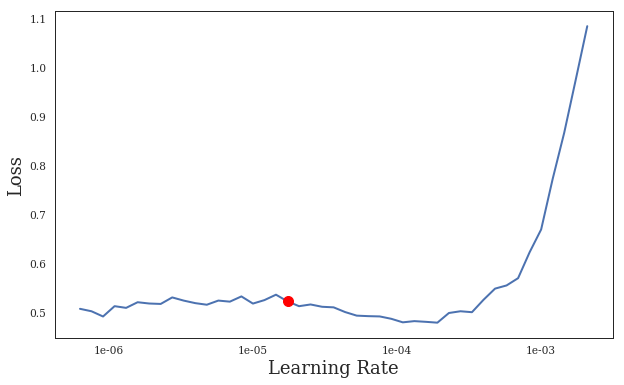

In [31]:
resnet.lr_find()
resnet.recorder.plot(suggestion=True)

En este caso parece que la pendiente que nos interesa se sitúa en el intervalo [$1e-5, 1e-4$], aunque sea muy poco pronunciada.

epoch,train_loss,valid_loss,accuracy,time
0,0.522260,0.752009,0.791769,01:03
1,0.567421,0.767392,0.787469,01:02
2,0.550670,0.762475,0.791769,01:03
3,0.517881,0.762467,0.799754,01:02
4,0.490454,0.730579,0.808354,01:03
5,0.423673,0.693638,0.813882,01:02
6,0.388161,0.665369,0.821867,01:02
7,0.383048,0.647006,0.828010,01:02
8,0.321301,0.641718,0.828010,01:03
9,0.308343,0.641867,0.826167,01:03


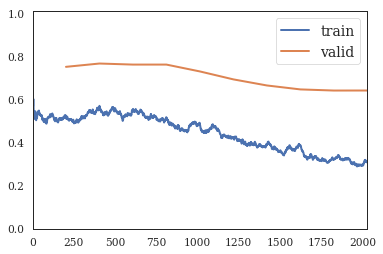

In [32]:
max_resnet_lr_unfreeze = 1e-3
resnet.fit_one_cycle(unfreeze_epochs, max_lr=slice(max_resnet_lr_unfreeze/100, max_resnet_lr_unfreeze/10))

Pues parece que no ibamos mal encaminados ya que hemos llegado al 82.6% de precisión, un resultado bastante bueno y sin una gran mejora con respecto al modelo con las capas bloqueadas, tal y como pasaba con VGG, aunque en este caso ha sido un poco mayor ya que la pendiente óptima para el learning rate se situaba en valores un poco mas elevados.

### InceptionV3

En el caso de Inception, no hemos hecho comparativa ya que no había muchas opciones, tan solo nos hemos quedado
con la v3 en lugar de la v4, algo que por otra parte tampoco afecta mucho ya que ofrece unos resultados **realmente buenos**.
Además, esta red de por si tiene como últimas capas una convolución 1x1 y una capa lineal
para la clasificación. Sorprendentemente, utilizar toda la arquitectura cambiando exclusivamente
el número de neuronas de salida, ofrece mejores resultados (+5%) de precisión que
eliminando las dos últimas capas y añadiendo nuestro clasificador explicado anteriormente.

In [26]:
def inception_loss(preds, target, **kwargs):
    """
    Debido a que InceptionV3 no está definida por defecto
    en fastai, es necesario modificar la función de loss
    de entropía cruzada para adaptarla convenientemente.
    """
    if isinstance(preds, tuple):
        return sum((F.cross_entropy(o, target, **kwargs) for o in preds))
    return F.cross_entropy(preds, target, **kwargs)

def inception_model(pretrained=True):
    """
    Importamos y ajustamos el modelo de InceptionV3 desde PyTorch
    ya que no viene por defecto en fastai. Tan solo debemos ajustar
    la última capa lineal para adecuarla al número de clases de nuestro
    problema.
    """
    model = torch_models.inception_v3(pretrained=pretrained)
    # Cambiamos la cantidad de neuronas en el output por tantas
    # como clases tenemos.
    model.fc = nn.Linear(2048, data.c, bias=True)
    return model

In [ ]:
# Ahora en lugar de cnn_learner que acoplaba el clasificador
# comentado anteriormente, debemos usar la clase Learner, que
# simplemente no acopla nada, pero en el resto es igual.
inception = Learner(
    inception_data,
    inception_model(),
    metrics=[accuracy],
    loss_func=inception_loss,
    callback_fns=get_callbacks()
)

# Creamos grupos para cuando entrenemos la red con todas
# las capas desbloqueadas
inception = inception.split(lambda m: list(m.children())[-1])

Primero vamos a ver cual es el valor máximo de $lr$ para esta red.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 1.32E-03


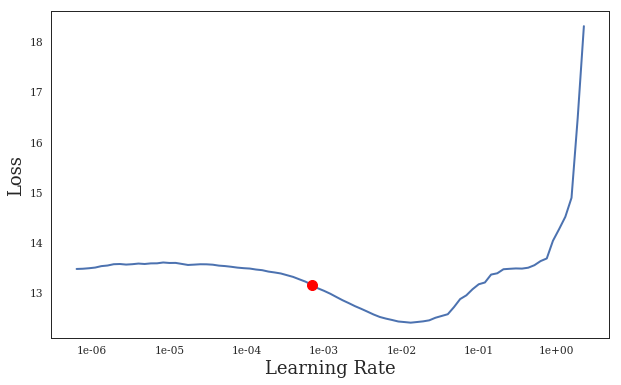

In [36]:
inception.lr_find()
inception.recorder.plot(suggestion=True)

Para el caso de este modelo parece que no vamos a poder quedarnos con el valor de $1e-2$ que hemos venido usando, ya que aunque justo en este valor se produce el mínimo de la curva, recordemos que nos interesa un valor un poco más pequeño que ese para evitar que el loss pueda no converger, por tanto parece que por ejemplo $1e-3$ es un buen valor. Veamos qué resultados generales ofrece y especificados por época:

epoch,train_loss,valid_loss,accuracy,time
0,9.889288,4.533754,0.095209,01:31
1,5.927627,2.762989,0.286241,01:37
2,4.318748,2.098912,0.418919,01:41
3,3.798950,1.945110,0.469902,01:41
4,2.983994,1.478995,0.580467,01:42
5,2.364187,1.793443,0.551597,01:42
6,1.861951,1.073842,0.704545,01:42
7,1.408078,0.912565,0.744472,01:43
8,0.991273,0.819444,0.783170,01:42
9,0.710325,0.651915,0.815111,01:41


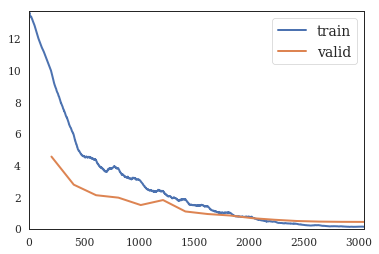

In [37]:
inception.fit_one_cycle(epochs, max_lr=1e-3)

Como deciamos previamente, esta red ofrece unos resultados fantásticos, **rozando la barrera del 90%**. Vamos a ver si conseguimos superarlo desbloqueando la red entera.

In [39]:
inception.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-05
Min loss divided by 10: 1.91E-05


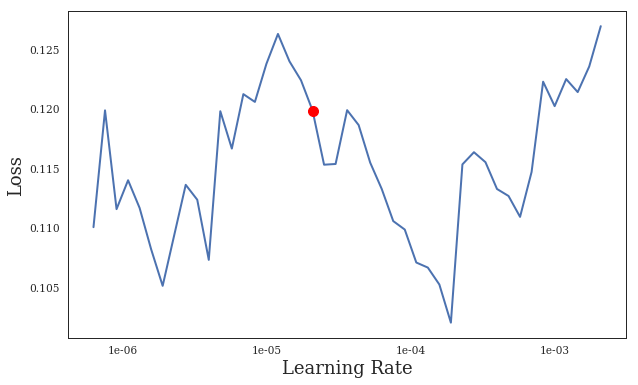

In [40]:
inception.lr_find()
inception.recorder.plot(suggestion=True)

En este caso vemos que la gráfica del learning rate fluctúa mucho, pero hay una zona con una clara pendiente descendente, el intervalo $[1e-5, 1e-4]$, por tanto nos quedaremos con ese, aunque si nos fijamos en los valores de loss realmente la diferencia entre maximos y mínimos de la gráfica es bastante pequeña.

epoch,train_loss,valid_loss,accuracy,time
0,0.110805,0.412435,0.885749,01:42
1,0.104972,0.416299,0.891278,01:41
2,0.107664,0.418458,0.894349,01:43
3,0.099120,0.420330,0.892506,01:43
4,0.101199,0.421537,0.888206,01:43


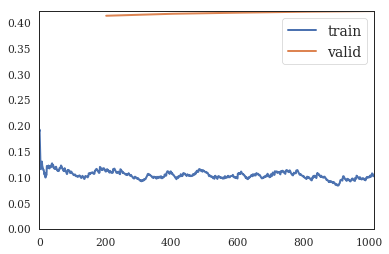

In [41]:
max_inception_lr_unfreeze = 1e-3
inception.fit_one_cycle(unfreeze_epochs, max_lr=slice(max_inception_lr_unfreeze/100, max_inception_lr_unfreeze/10))

En este caso el desbloquear las capas ha servido de bastante poco ya que no se produce ninguna mejora (gráfica constante para validación), pero debemos de tener en cuenta que los resultados de por si son bastante buenos, asi que tampoco nos quejaremos.

### EfficientNet

Para esta arquitectura, al igual que con Inception, nos hemos dado cuenta de que era innecesario cortar
la red y añadir nuestro clasificador, ya que esta red viene con clasificador basado en AveragePooling + BN + Dropout + Linear. Este clasificador es muy similar al que nosotros utilizamos en el resto de arquitecturas así que lo hemos
utilizado tal cuál (cambiando las neuronas de salida exclusivamente). Sorprendentemente, también nos hemos dado
cuenta que el rendimiento es mejor cuando se entrena con toda la red descongelada, en lugar de realizar un
entrenamiento multietapa.

Antes de ver los resultados obtenidos con esta red, vamos a ver el número de parámetros de cada versión y los resultados que han ofrecido en ImageNet:

|     **Nombre**    | **Params** |  **Top-1 Acc** |
|:-----------------:|:----------:|:--------------:|
| `efficientnet-b0` |    5.3M    |      76.3      |
| `efficientnet-b1` |    7.8M    |      78.8      |
| `efficientnet-b2` |    9.2M    |      79.8      |
| `efficientnet-b3` |     12M    |      81.1      |
| `efficientnet-b4` |     19M    |      82.6      |
| `efficientnet-b5` |     30M    |      83.3      |
| `efficientnet-b6` |     43M    |      84.0      |
| `efficientnet-b7` |     66M    |      84.4      |

A simple vista, parece que donde más nos interesaría quedarnos debido a nuestra capacidad limitada de cómputo es hasta la B4, ya que desde esa versión en adelante, el número de parámetros crece mucho más que en las versiones más simples, y todo ello para una ganancia de precisión muy reducida. Veamos si coinciden estos datos con los obtenidos en nuestro problema.

![Evolución de las distintas variantes de EfficientNet](plots/efn_acc.png)

Como podemos ver, todas ellas ofrecen unos muy buenos resultados **por encima del 85%** de precisión en todas las versiones, solo las versiones con mayor número de parámetros llegan a obtener los mismos resultados que InceptionV3.

![Accuracy EfficientNet en la última época](plots/efn_hist.png)

Ahora bien, en nuestro caso tambien nos interesa mucho el tiempo de cómputo, y en esta red se incrementa drásticamente a partir de la versión B4. Veamos la precisión normalizada con respecto al tiempo para verificar esto:

![Resultados en precisión/tiempo](plots/efn_normalized_acc.png)

Según estos datos, la versión que más nos interesaría sería la B0, pero realmente nos vamos a quedar con la B1 ya que se sitúa entre la B0 y la B2 pero teniendo un 2% extra de precisión con respecto a éstas y con un incremento del número de parámetros minúsculo (en comparación con las versiones mayores), ofreciendo unos resultados practicamente iguales que las versiones con muchos parámetros y por tanto necesitaremos mucho menos cómputo para alcanzar un resultado muy bueno.

In [29]:
def efn(name):
    """
    Obtenemos la red de EfficientNet con la última capa lineal
    ya ajustada al número de clases de nuestro problema.
    """
    return EfficientNet.from_pretrained(name, num_classes=data.c)

In [49]:
efficientnet = Learner(
    data,
    efn('efficientnet-b1'),
    metrics=[accuracy],
    callback_fns=get_callbacks()
).mixup()

efficientnet = efficientnet.split(lambda m: list(m.children())[-2])

Loaded pretrained weights for efficientnet-b1


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 7.59E-04


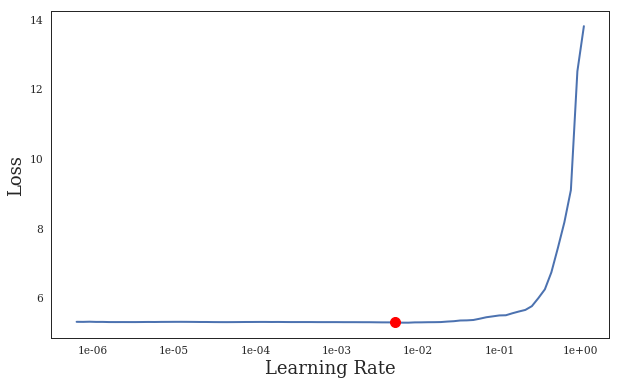

In [50]:
efficientnet.lr_find()
efficientnet.recorder.plot(suggestion=True)

La gráfica resultante en este caso es bastante curiosa ya que no presenta una pendiente descendente como tal, tan solo se ve como empieza a aumentar cuando llegamos al intervalo $[1e-2, 1e-1]$, y por supuerto para valores mayores. Por tanto vamos a ser conservadores en este caso y cogeremos un valor de $1e-3$, ya que en ese valor la gráfica no presenta ningun problema.

epoch,train_loss,valid_loss,accuracy,time
0,5.227412,5.101309,0.055283,01:33
1,4.308839,3.233348,0.233415,01:32
2,3.110539,1.985912,0.458845,01:32
3,2.610569,1.574086,0.562654,01:32
4,2.350602,1.278535,0.651720,01:32
5,2.078332,1.182638,0.689189,01:32
6,1.926143,1.113846,0.702703,01:32
7,1.813438,0.876248,0.763514,01:33
8,1.682191,0.741213,0.794840,01:32
9,1.532222,0.551141,0.849509,01:32


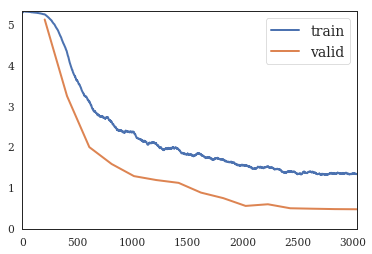

In [51]:
efficientnet.fit_one_cycle(epochs, max_lr=1e-3)

Como era de esperar, los resultados son bastante buenos, rozando también la barrera del 90%. En este caso hemos empleado directamente la técnica MixUp, por lo tanto era de esperar que el error de entrenamiento sea más elevado que en InceptionV3. Pero esto no es algo malo ya que seguramente Inceptión dará unos resultados en test peores que EfficienNet ya que con Inception no aplicamos ningún tipo de regularización aparte de los parámetros preestablecidos de data augmentation, y por tanto seguramente EfficientNet tendrá mayor capacidad de generalización.

Vamos a ver qué sucede cuando desbloqueamos las capas de esta red y entrenamos con su máximo potencial.

In [25]:
efficientnet.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 8.32E-07


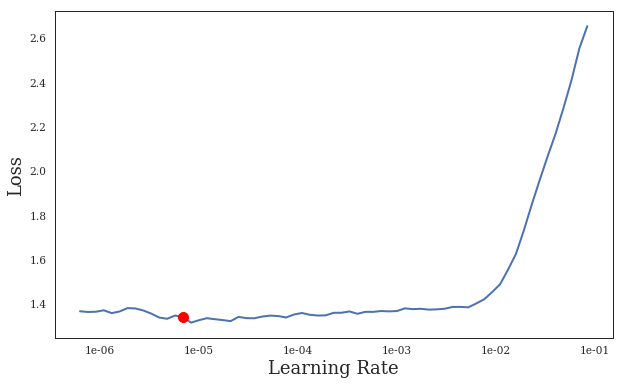

In [27]:
efficientnet.lr_find()
efficientnet.recorder.plot(suggestion=True)

La gráfica se parece mucho a la anterior, por lo que vamos a quedarnos con el intervalo $[1e-4, 1e-3$].

epoch,train_loss,valid_loss,accuracy,time
0,1.345447,0.468125,0.878993,02:41
1,1.338827,0.466004,0.879607,02:41
2,1.332313,0.461581,0.880221,02:42
3,1.309260,0.462850,0.879607,02:42
4,1.323787,0.461843,0.880835,02:41
5,1.354131,0.462416,0.880835,02:42
6,1.313343,0.459521,0.885749,02:42
7,1.305805,0.458851,0.888206,02:42
8,1.286023,0.460623,0.885749,02:42
9,1.321634,0.458288,0.885135,02:41


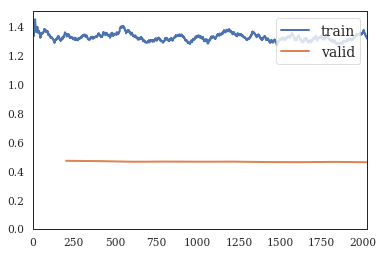

In [28]:
max_efn_lr_unfreeze = 1e-2
efficientnet.fit_one_cycle(unfreeze_epochs, max_lr=slice(max_efn_lr_unfreeze/100, max_efn_lr_unfreeze/10))

Parece que nos ha pasado lo mismo que con Inception, no se produce apenas mejora, algo de esperar ya que como hemos dicho el rango del learning rate ha sido muy bajo.

### ResNeXt WSL

Para añadir más variedad a la comparativa hemos entrenado una última arquitectura, ResNeXt101 [@weaklySupervised],
pero no preentrenada sobre ImageNet. En este caso, vamos a utilizar una versión llamada
ResNeXt WSL, la cual ha sido entrenada de forma debilmente-supervisada [@weaklySupervised] sobre
940 millones de imágenes públicas de Instagram, seguido de un fine-tuning sobre ImageNet1K.
Este modelo en concreto, alcanza una precisión SOTA en ImageNet por encima del resto de arquitecturas
(incluido EfficientNet B7).

In [39]:
# Código adaptado del repositorio fastai_extensions
# https://github.com/oguiza/fastai_extensions/blob/master/fastai_extensions/
class CutMixCallback(LearnerCallback):
    '''Adapted from :
    paper: https://arxiv.org/abs/1905.04899
    github: https://github.com/clovaai/CutMix-PyTorch
    and mixup in the fastai library.'''

    def __init__(self, learn:Learner, alpha:float=1., stack_y:bool=True):
        super().__init__(learn)
        self.alpha = alpha
        self.stack_y = stack_y

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies cutmix to `last_input` and `last_target` if `train`."
        if not train or self.alpha == 0: return
        λ = np.random.beta(self.alpha, self.alpha)
        λ = max(λ, 1- λ)
        bs = last_target.size(0)
        idx = torch.randperm(bs).to(last_input.device)
        x1, y1 = last_input[idx], last_target[idx]

        #Get new input
        last_input_size = last_input.size()
        bbx1, bby1, bbx2, bby2 = rand_bbox(last_input_size, λ)
        new_input = last_input.clone()
        new_input[..., bby1:bby2, bbx1:bbx2] = x1[..., bby1:bby2, bbx1:bbx2]
        #λ = last_input.new([λ])
        λ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
        λ = last_input.new([λ])

        # modify last target
        if self.stack_y:
            new_target = torch.cat([last_target.unsqueeze(1).float(), y1.unsqueeze(1).float(),
                                    λ.repeat(last_input_size[0]).unsqueeze(1).float()], 1)
        else:
            if len(last_target.shape) == 2:
                λ = λ.unsqueeze(1).float()
            new_target = last_target.float() * λ + y1.float() * (1-λ)

        return {'last_input': new_input, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''
    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    
    if len(last_input_size) == 4:
        bby2 = np.clip(cy + cut_h // 2, 0, H)
    else: bby2 = last_input_size[1]

    return bbx1, bby1, bbx2, bby2


def cutmix(learn:Learner, alpha:float=1., stack_x:bool=False, stack_y:bool=True) -> Learner:
    "Add cutmix https://arxiv.org/pdf/1905.04899.pdf to `learn`."
    learn.callback_fns.append(partial(CutMixCallback, alpha=alpha, stack_y=stack_y))
    return learn

In [40]:
def resnext32x8d_WSL_model(pretrained=False):
    model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
    all_layers = list(model.children())
    return nn.Sequential(*list(children(model)))

resnext_WSL = cnn_learner(
    data,
    resnext32x8d_WSL_model,
    pretrained=True,
    metrics=[accuracy],
    callback_fns=get_callbacks(),
    cut=-2,
    ps=0.4,
    split_on=lambda m: (m[0][6], m[1])
)

Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master


Siguiendo el mismo procedimiento que antes, vamos a ver su gráfica de learning rate:

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 1.91E-03


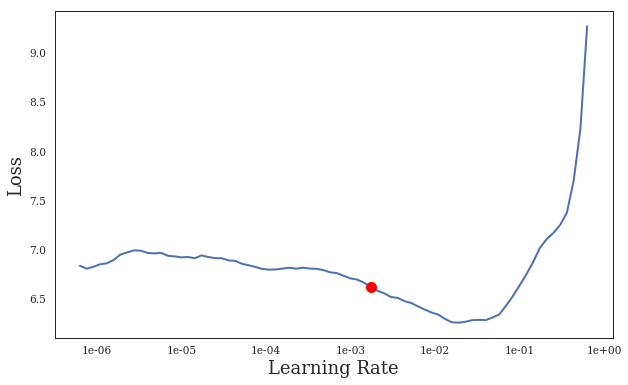

In [41]:
resnext_WSL.lr_find()
resnext_WSL.recorder.plot(suggestion=True)

En este caso parece que $1e-2$ es el mejor.

epoch,train_loss,valid_loss,accuracy,time
0,3.711457,2.393742,0.386978,02:18
1,2.239973,1.572933,0.587224,02:18
2,2.092105,1.983579,0.561425,02:18
3,1.966383,1.628613,0.591523,02:18
4,1.455771,1.241706,0.674447,02:18
5,1.249660,1.026278,0.719287,02:18
6,1.067323,0.895331,0.754914,02:18
7,0.887469,0.792376,0.783170,02:18
8,0.668539,0.687263,0.807740,02:18
9,0.506504,0.617237,0.834152,02:18


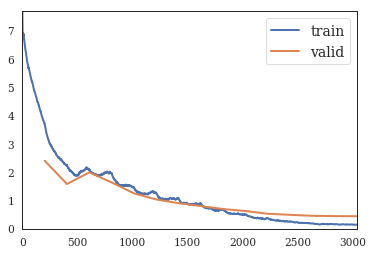

In [42]:
resnext_WSL.fit_one_cycle(epochs, max_lr=1e-2)

Pues viendo los resultados, parece que no ha estado nada mal el incluir este modelo en la comparativa, ya que alcanza unos resultados muy buenos, **rozando el 90%** como InceptionV3 o EfficientNet. Veamos que sucede al descongelar las capas.

In [45]:
resnext_WSL.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 2.51E-06


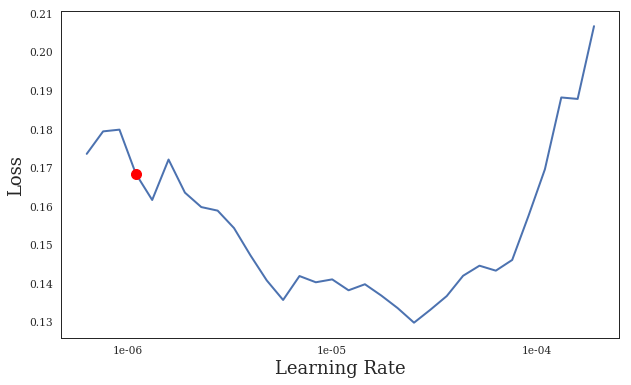

In [46]:
resnext_WSL.lr_find()
resnext_WSL.recorder.plot(suggestion=True)

Viendo la gráfica vamos a situar el intervalo en la pendiente situada en el intervalo [$1e-6$, $1e-5$].

In [ ]:
max_resnext_lr_unfreeze = 1e-4
resnext_WSL.fit_one_cycle(unfreeze_epochs, max_lr=slice(max_resnext_lr_unfreeze/100, max_resnext_lr_unfreeze/10))

## Resultados Test

Una vez que hemos terminado el entrenamiento de todos los modelos que habiamos definido, es hora de ver que tal se comportan en el conjunto de test. Veamos una gráfica con el loss y la precisión de cada modelo:

In [20]:
def evaluate_model(model):
    test_data = get_data(test, valid_ptc=0.0)
    return model.validate(test_data.train_dl)

def set_annotations(barplot):
    for p in barplot.patches:
        barplot.annotate(
            format(p.get_height(), '.4f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center',
            va = 'center',
            fontsize=12,
            xytext = (0, 10),
            textcoords = 'offset points'
        )

In [21]:
# Cargamos los modelos preentrenados
vgg = load_learner(path='models/vgg', file='vgg_unfreeze.pkl')
resnet = load_learner(path='models/resnet', file='resnet_unfreeze.pkl')
inception = load_learner(path='models/inception', file='inception_unfreeze.pkl')
inception = inception.split(lambda m: list(m.children())[-1])
efficientnet = load_learner(path='models/efficientnet', file='efficientnet_unfreeze_mixup.pkl')
efficientnet = efficientnet.splitlambda m: list(m.children())[-2])
resnext_WSL = load_learner(path='models/resnext', file='resnext_unfreeze.pkl')

In [ ]:
# Obtenemos los resultados en test de cada modelo
vgg_results = evaluate_model(vgg)
resnet_results = evaluate_model(resnet)
inception_results = evaluate_model(inception)
efficientnet_results = evaluate_model(efficientnet)
resnext_results = evaluate_model(resnext_WSL)

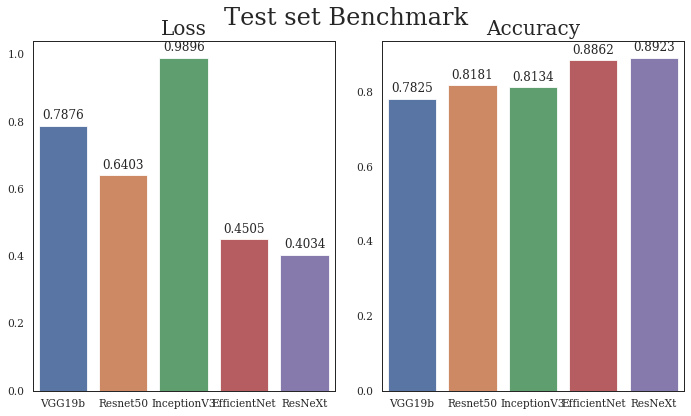

In [24]:
results = [vgg_results, resnet_results, inception_results, efficientnet_results, resnext_results]
models = ['VGG19b', 'Resnet50', 'InceptionV3', 'EfficientNet', 'ResNeXt']
accuracies = [acc.item() for _, acc in results]
losses = [loss for loss, _ in results]

fig, axes = plt.subplots(1, 2)
axes[0].set_title('Loss')
axes[1].set_title('Accuracy')
g1 = sns.barplot(x=models, y=accuracies, ax=axes[1])
g2 = sns.barplot(x=models, y=losses, ax=axes[0])

set_annotations(g1)
set_annotations(g2)

plt.tight_layout()
plt.suptitle('Test set Benchmark')
plt.show()

Como podemos ver, todos los modelos salvo 1 ofrecen unos resultados muy similares a los obtenidos en validación durante el entrenamiento. El caso de InceptionV3 es el más extraño, ya que tiene un loss y una precisión peores que los previstos, pero hay que tener en cuenta una cosa, y es que con InceptionV3 no hemos aplicado una regularización extra como en el caso de EfficientNet o ResNeXt, donde se aplicó MixUp y CutMix respectivamente. Esto seguramente sea el causante de que InceptionV3 haya perdido un poco de generalización con respecto a sus rivales directos.

# Mejoras

Pese a obtener una precisión bastante alta en el conjunto de test, el estado
del arte para este conjunto de datos está en un 96% de precisión, eso indica
que aún se puede seguir mejorando. Por motivos de limitación, nos hemos dejado
en el tintero algunas mejoras que se podrían realizar. Después de investigar
diferentes técnicas y trucos para el entrenamiento eficiente de CNNs, hemos
recopilado una lista de mejoras que se pueden implementar en desarrollos futuros:


1. **Optimizador**: En lugar de utilizar Adam para entrenar los diferentes
modelos, utilizar RAdam [@radam], o incluso Ranger, que es una combinación de RAdam + Lookahead [@ranger].

2. **Enfriamiento de coseno (cosine annealing)**: En lugar de usar una política de actualización
de pesos triangular (arriba y abajo) como utiliza OneCycle, hacer uso de una actualización
basada en el coseno [@bagOfTricks]: se parte de un LR alto y se va decrementando conforme pasan las épocas.
También se puede utilizar un calentamiento para el LR donde en las primeras épocas se utiliza
un valor bajo y cuando el entrenamiento es estable, se incrementa. Ambas opciones se pueden
combinar: se realiza un calentamiento y cuando el LR se ha incrementado, se sigue la política
del coseno para actualizarlo a lo largo de las épocas restantes. El motivo principal por el
que sustituir OneCycle por estos esquemas, es que OneCycle suele funcionar bien con SGD o Adam,
pero en optimizador más modernos y complejos, el esquema cíclico triangular no suele funcionar
tan bien. Nuestro consejo es utilizar OneCycle mientras se esté utilizando Adam o SGD, en 
caso de usar un optimizador más complejo, deberíamos cambiar a otro esquema de actualización.


3. **Función de activación Mish en lugar de ReLU**: Mish [@mish] es una función de activación nueva (2019),
que ofrece una curva mucho más suave que la de ReLU y a pesar que provoca que el entrenamiento
sea más lento, suele producir unas mejoras significativas en la precisión (ver paper).


4. **Capa de Self-Attention**: Añadir una capa de Self-Attention [@selfAttention] ayuda a la CNN a
enfocarse en dependencias globales de la imagen, en lugar de en dependencias locales
como hacen las convoluciones.

# Conclusiones

Aun así, a pesar de todas las mejoras extra que se podrian haber aplicado, los resultados son más que satisfactorios, llegando muy cerca del SOTA y con unos recursos limitados, tanto en tiempo como en potencia. El hecho de haber aplicado técnicas como One-Cycle y una buena regularización ha sido clave en la obtención de los resultados.

# Referencias

[@rangeTest]: https://arxiv.org/abs/1506.01186

[@oneCycle]: https://arxiv.org/abs/1803.09820

[@superconvergence]: https://arxiv.org/abs/1708.07120

[@layerSpecificLR]: https://arxiv.org/abs/1510.04609

[@mixup]: https://arxiv.org/abs/1710.09412

[@cutmix]: https://arxiv.org/abs/1905.04899

[@radam]: https://arxiv.org/abs/1908.03265

[@ranger]: https://arxiv.org/abs/1907.08610

[@bagOfTricks]: https://arxiv.org/abs/1812.01187

[@mish]: https://arxiv.org/abs/1908.08681v1

[@selfAttention]: https://arxiv.org/abs/1906.05909

[@weakySupervised]: https://arxiv.org/abs/1805.00932